# Final Project
## Exploring Techniques and Applications of Natural Language Processing
___
### Matt Oehler
#### 12/11/2018

### Table of Contents

1. SMS Spam Classification
    - compare results of different models with differnt text vectorization methods
2. Consumer Complaint Data
    - use TF-IDF under 3 different models on a multiclass classification problem
3. Word2Vec
    - a simple demonstration of word2vec


In [1]:
#import libraries
#data loading and manipulation
import numpy as np
import pandas as pd
import pickle
from io import StringIO
import itertools
from sklearn.model_selection import train_test_split

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

#try different methods for text vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
import gensim

#algorithms
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


#metrics
import time #used to get training time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

C:\Users\Matt\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#### Helper Functions

In [2]:
## make images of results ##
#make a good confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,save = None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    if(save):
        plt.savefig(save)

In [3]:
def train_model(model,X,y,test_x = None, test_y = None):
    """given a vectorizer and a model, train and print out accuracy
    """
    train_start = time.time()
    model.fit(X,y)
    train_end = time.time()
    print('Training complete in', np.round(train_end-train_start,4), 'seconds.')
    preds = model.predict(test_x)
    print(classification_report(y_test, preds),"\n")
    print(confusion_matrix(y_test,preds))
    return model

## SMS Spam Classification

First I did what I would consider the "Hello World" of NLP. I used various types of vectorizers to assess how they perform when classifying spam/ham SMS messages. As always the first thing I did is read in the data and summarize/visualize it.

In [4]:
#read in dataset of text messages
sms_data = pd.read_table('SMSSpamCollection',
                   sep='\t', 
                   header=None, 
                   names=['label', 'text'])
print(sms_data.shape)
sms_data.head()

(5572, 2)


,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
#are the labels balanced?
sms_data.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

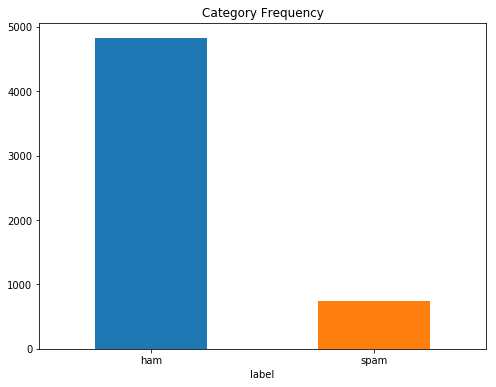

In [6]:
fig = plt.figure(figsize=(8,6))
sms_data.groupby('label').text.count().plot.bar(ylim=0,rot=0)
plt.title("Category Frequency")
plt.savefig("SMS_categories.png")
plt.show()

We can see that the labels are quite imbalanced with only a small portion of them being spam. Knowing such, I chose to use F1-score as my evaluation metric rather than just raw accuracy.

In [7]:


#this one didn't work
# tf_trans = TfidfTransformer()
# tf_trans_fit = tf_trans.fit_transform(sms_data.text.values)

# hashvec = HashingVectorizer()
# hash_fit = hashvec.fit_transform(sms_data.text.values)

Now we'll use iterate over the different vectorizers using different model types and compare the results

In [8]:
#let the battle begin!!!
#vectorizing the text
count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(sms_data.text.values)

#make data with bag of words
X_train, X_test, y_train, y_test = train_test_split(counts, sms_data.label, test_size=0.25, random_state=111)

#train vectorizer
# count_vectorizer = CountVectorizer()
# counts = count_vectorizer.fit_transform(X_train.text.values)



print("Bag of Words\n")
print("\nNaive Bayes")
NB = MultinomialNB()
NB_bag = train_model(NB, X_train, y_train, X_test, y_test)
# print("\nSupport Vector Machines")
# SVM = SVC()
# train_model(SVM, X_train, y_train, X_test, y_test)
print("\nRandom Forrest Classifier")
RF = RandomForestClassifier()
RF_bag = train_model(RF, X_train, y_train, X_test, y_test)
print("\nXGBoost")
xgb = XGBClassifier()
xgb_bag = train_model(xgb, X_train, y_train, X_test, y_test)


Bag of Words


Naive Bayes
Training complete in 0.0179 seconds.
             precision    recall  f1-score   support

        ham       0.99      0.99      0.99      1198
       spam       0.93      0.93      0.93       195

avg / total       0.98      0.98      0.98      1393
 

[[1185   13]
 [  14  181]]

Random Forrest Classifier
Training complete in 0.5126 seconds.
             precision    recall  f1-score   support

        ham       0.97      1.00      0.98      1198
       spam       0.99      0.80      0.89       195

avg / total       0.97      0.97      0.97      1393
 

[[1197    1]
 [  39  156]]

XGBoost
Training complete in 0.8406 seconds.
             precision    recall  f1-score   support

        ham       0.97      1.00      0.98      1198
       spam       0.99      0.82      0.89       195

avg / total       0.97      0.97      0.97      1393
 

[[1196    2]
 [  36  159]]


C:\Users\Matt\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix, without normalization
Confusion matrix, without normalization


C:\Users\Matt\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix, without normalization


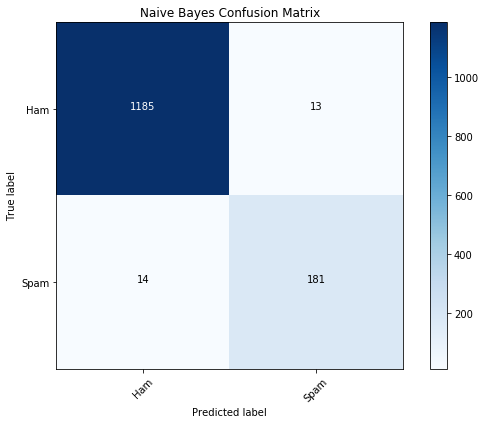

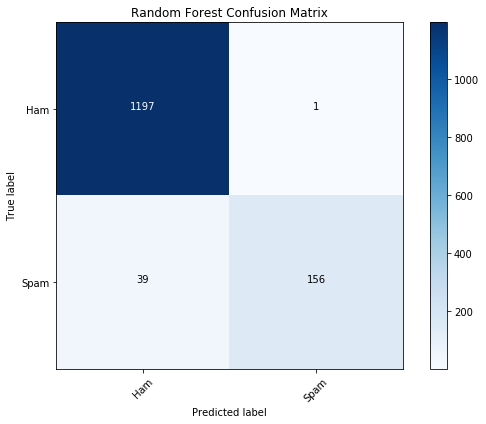

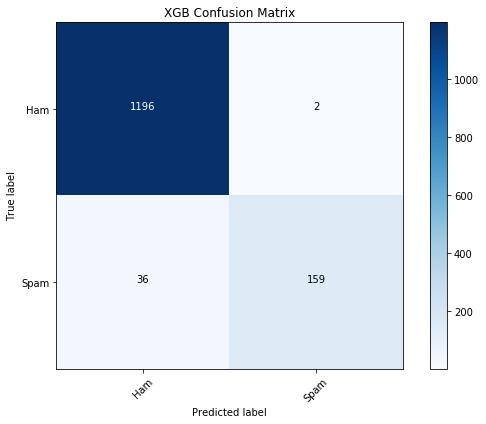

In [9]:
#make nice confusion matrix

model_best = NB_bag
# class_names = list(model_best.classes_)
class_names = ["Ham","Spam"]

preds = model_best.predict(X_test)
#make sure that the labels are correct
cnf_matrix = confusion_matrix(y_test,preds)

plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Naive Bayes Confusion Matrix',
                      save = "NBbag.png")
# plt.show()

model_best = RF_bag
# class_names = list(model_best.classes_)
class_names = ["Ham","Spam"]

preds = model_best.predict(X_test)
#make sure that the labels are correct
cnf_matrix = confusion_matrix(y_test,preds)

plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Random Forest Confusion Matrix',
                      save = "RFbag.png")
# plt.show()


model_best = xgb_bag
# class_names = list(model_best.classes_)
class_names = ["Ham","Spam"]

preds = model_best.predict(X_test)
#make sure that the labels are correct
cnf_matrix = confusion_matrix(y_test,preds)

plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='XGB Confusion Matrix',
                      save = "xgbbag.png")
# plt.show()


In [10]:
#make data with tfidf
tfvec = TfidfVectorizer()
tf_idf = tfvec.fit_transform(sms_data.text.values)

X_train, X_test, y_train, y_test = train_test_split(tf_idf, sms_data.label, test_size=0.25, random_state=111)

print("TF-IDF\n")
print("\nNaive Bayes")
NB = MultinomialNB()
NB_tf = train_model(NB, X_train, y_train, X_test, y_test)
# print("\nSupport Vector Machines")
# SVM = SVC()
# train_model(SVM, X_train, y_train, X_test, y_test)
print("\nRandom Forrest Classifier")
RF = RandomForestClassifier()
RF_tf = train_model(RF, X_train, y_train, X_test, y_test)
print("\nXGBoost")
xgb = XGBClassifier()
xgb_tf = train_model(xgb, X_train, y_train, X_test, y_test)


TF-IDF


Naive Bayes
Training complete in 0.019 seconds.
             precision    recall  f1-score   support

        ham       0.95      1.00      0.98      1198
       spam       1.00      0.69      0.82       195

avg / total       0.96      0.96      0.95      1393
 

[[1198    0]
 [  60  135]]

Random Forrest Classifier
Training complete in 0.4827 seconds.
             precision    recall  f1-score   support

        ham       0.97      1.00      0.98      1198
       spam       1.00      0.79      0.88       195

avg / total       0.97      0.97      0.97      1393
 

[[1198    0]
 [  41  154]]

XGBoost
Training complete in 1.0312 seconds.
             precision    recall  f1-score   support

        ham       0.97      0.99      0.98      1198
       spam       0.95      0.83      0.89       195

avg / total       0.97      0.97      0.97      1393
 

[[1190    8]
 [  33  162]]


C:\Users\Matt\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization


C:\Users\Matt\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


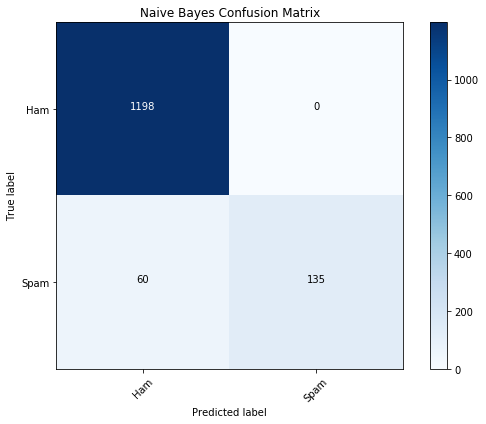

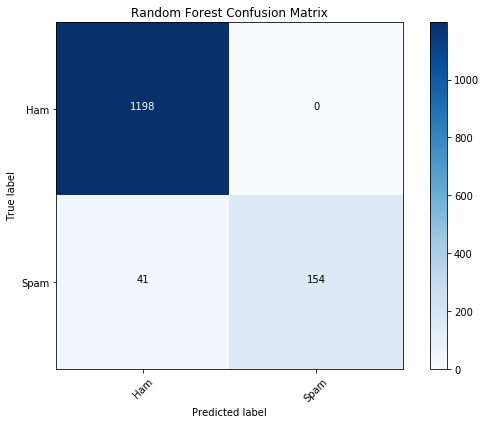

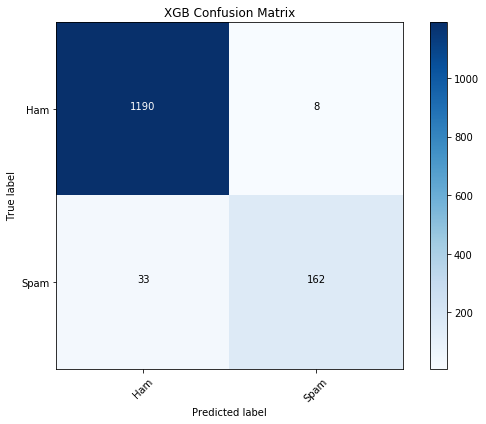

In [11]:
#make nice confusion matrix

model_best = NB_tf
# class_names = list(model_best.classes_)
class_names = ["Ham","Spam"]

preds = model_best.predict(X_test)
#make sure that the labels are correct
cnf_matrix = confusion_matrix(y_test,preds)

plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Naive Bayes Confusion Matrix',
                      save = "NBtf.png")
# plt.show()

model_best = RF_tf
# class_names = list(model_best.classes_)
class_names = ["Ham","Spam"]

preds = model_best.predict(X_test)
#make sure that the labels are correct
cnf_matrix = confusion_matrix(y_test,preds)

plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Random Forest Confusion Matrix',
                      save = "RFtf.png")
# plt.show()


model_best = xgb_tf
# class_names = list(model_best.classes_)
class_names = ["Ham","Spam"]

preds = model_best.predict(X_test)
#make sure that the labels are correct
cnf_matrix = confusion_matrix(y_test,preds)

plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='XGB Confusion Matrix',
                      save = "xgbtf.png")
# plt.show()


In [12]:
### THIS IS ANOTHER TECHNIQUE THAT I CHOSE NOT TO EXPLORE IN DEPTH

# #make data with hash-vectorizer
# X_train, X_test, y_train, y_test = train_test_split(hash_fit, sms_data.label, test_size=0.25, random_state=111)

# print("Hash Vectorizing\n")
# print("\nNaive Bayes")
# # NB = MultinomialNB()
# # train_model(NB, X_train, y_train, X_test, y_test)

# # print("\nSupport Vector Machines")
# # SVM = SVC()
# # train_model(SVM, X_train, y_train, X_test, y_test)
# print("\nRandom Forrest Classifier")
# RF = RandomForestClassifier()
# RF_hash = train_model(RF, X_train, y_train, X_test, y_test)
# print("\nXGBoost")
# xgb = XGBClassifier()
# xgb_hash = train_model(xgb, X_train, y_train, X_test, y_test)


The results above indicate that XGBoost performed the best (had the best F1-Score) for all cases. This isn't really surprising given that XGBoost is notable for its out-of-the-box performance.

#### Multiclass Document Classification
- Here we use a data set of customer compaints which fall under one of several categories
- The dataset can be downloaded [here](https://catalog.data.gov/dataset/consumer-complaint-database)

In [13]:
#read in customer-complaints
df = pd.read_csv("Consumer_Complaints.csv")
print(df.shape)
df.head()

(1175538, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,03/12/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,03/17/2014,Closed with explanation,Yes,No,759217
1,01/19/2017,Student loan,Federal student loan servicing,Dealing with my lender or servicer,Received bad information about my loan,When my loan was switched over to Navient i wa...,NaN,"Navient Solutions, LLC.",LA,NaN,NaN,Consent provided,Web,01/19/2017,Closed with explanation,Yes,No,2296496
2,04/06/2018,Credit card or prepaid card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,I tried to sign up for a spending monitoring p...,NaN,CAPITAL ONE FINANCIAL CORPORATION,VA,NaN,Older American,Consent provided,Web,04/06/2018,Closed with explanation,Yes,NaN,2866101
3,06/08/2014,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,06/10/2014,Closed with explanation,Yes,Yes,885638
4,09/13/2014,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,09/13/2014,Closed with explanation,Yes,Yes,1027760


In [14]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.columns = ['Product', 'Consumer_complaint_narrative']
df['category_id'] = df['Product'].factorize()[0]
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)
df.head()

,Product,Consumer_complaint_narrative,category_id
1,Student loan,When my loan was switched over to Navient i wa...,0
2,Credit card or prepaid card,I tried to sign up for a spending monitoring p...,1
7,Mortgage,"My mortgage is with BB & T Bank, recently I ha...",2
13,Mortgage,The entire lending experience with Citizens Ba...,2
14,Credit reporting,My credit score has gone down XXXX points in t...,3


In [15]:
df.Product.value_counts()

Debt collection                                                                 79342
Credit reporting, credit repair services, or other personal consumer reports    77506
Mortgage                                                                        50050
Credit reporting                                                                31588
Student loan                                                                    19974
Credit card                                                                     18838
Credit card or prepaid card                                                     17782
Bank account or service                                                         14885
Checking or savings account                                                     10580
Consumer Loan                                                                    9473
Vehicle loan or lease                                                            4744
Money transfer, virtual currency, or money service    

In [16]:
keeps = ['Student loan', 'Credit reporting', 'Credit card', 'Credit card or prepaid card']
cc = df.loc[df['Product'].isin(keeps)]
cc['new_cat_id'] = pd.Categorical(cc.category_id).codes
print(cc.shape)
cc.head()

(88182, 4)


C:\Users\Matt\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Product,Consumer_complaint_narrative,category_id,new_cat_id
1,Student loan,When my loan was switched over to Navient i wa...,0,0
2,Credit card or prepaid card,I tried to sign up for a spending monitoring p...,1,1
14,Credit reporting,My credit score has gone down XXXX points in t...,3,2
77,Credit card or prepaid card,Alleged company use scare tactics to threaten ...,1,1
82,Credit reporting,On the credit report equifax there is a name l...,3,2


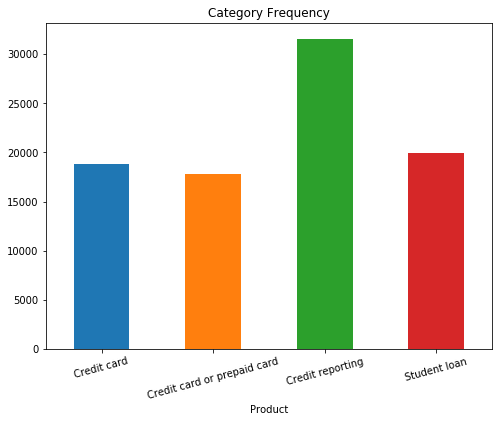

In [17]:
fig = plt.figure(figsize=(8,6))
cc.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0,rot=15)
plt.title("Category Frequency")
plt.savefig("CC_categories.png")
plt.show()

In [18]:
# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2',
#                         encoding='latin-1',
# #                         encoding='utf-8',
#                         ngram_range=(1, 1), stop_words='english')
# features = tfidf.fit_transform(cc.Consumer_complaint_narrative).toarray()

tfidf = TfidfVectorizer()
features = tfidf.fit_transform(cc.Consumer_complaint_narrative)#.toarray()
# labels = cc.category_id
features.shape

(88182, 50643)

In [19]:
#make train and test data
#make data with hash-vectorizer
X_train, X_test, y_train, y_test = train_test_split(features, cc.new_cat_id, test_size=0.25, random_state=111)

print("Consumer Complaints Dataset\n")
print("\nNaive Bayes")
NB = MultinomialNB()
NB_cc = train_model(NB, X_train, y_train, X_test, y_test)

print("\nRandom Forrest Classifier")
RF = RandomForestClassifier()
RF_cc = train_model(RF, X_train, y_train, X_test, y_test)

print("\nXGBoost")
xgb = XGBClassifier()
xgb_cc = train_model(xgb, X_train, y_train, X_test, y_test)

Consumer Complaints Dataset


Naive Bayes
Training complete in 0.0778 seconds.
             precision    recall  f1-score   support

          0       0.93      0.94      0.93      4935
          1       0.79      0.53      0.63      4502
          2       0.84      0.97      0.90      7920
          3       0.67      0.71      0.69      4689

avg / total       0.81      0.82      0.81     22046
 

[[4621   36  264   14]
 [ 122 2393  493 1494]
 [  92   34 7663  131]
 [ 132  576  665 3316]]

Random Forrest Classifier
Training complete in 56.0044 seconds.
             precision    recall  f1-score   support

          0       0.84      0.91      0.88      4935
          1       0.56      0.53      0.54      4502
          2       0.83      0.93      0.88      7920
          3       0.55      0.43      0.48      4689

avg / total       0.72      0.74      0.73     22046
 

[[4512   87  269   67]
 [ 269 2378  474 1381]
 [ 226  175 7342  177]
 [ 334 1616  732 2007]]

XGBoost
Training comple

C:\Users\Matt\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


#### Nice Confusion Matrices of the Results

C:\Users\Matt\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix, without normalization


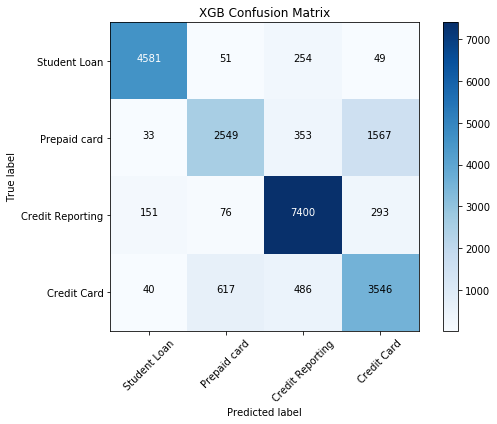

In [20]:
model_best = xgb_cc
# class_names = list(model_best.classes_)
class_names = ["Student Loan", "Prepaid card", "Credit Reporting", "Credit Card"]

preds = model_best.predict(X_test)
#make sure that the labels are correct
cnf_matrix = confusion_matrix(y_test,preds)

plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='XGB Confusion Matrix',
                      save = "xgbcm.png")
plt.show()

Confusion matrix, without normalization


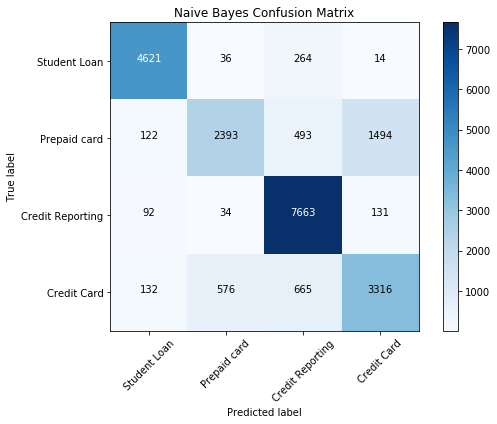

In [21]:
model_best = NB_cc
# class_names = list(model_best.classes_)
class_names = ["Student Loan", "Prepaid card", "Credit Reporting", "Credit Card"]

preds = model_best.predict(X_test)
#make sure that the labels are correct
cnf_matrix = confusion_matrix(y_test,preds)

plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Naive Bayes Confusion Matrix',
                      save = "NBcm.png")
plt.show()

Confusion matrix, without normalization


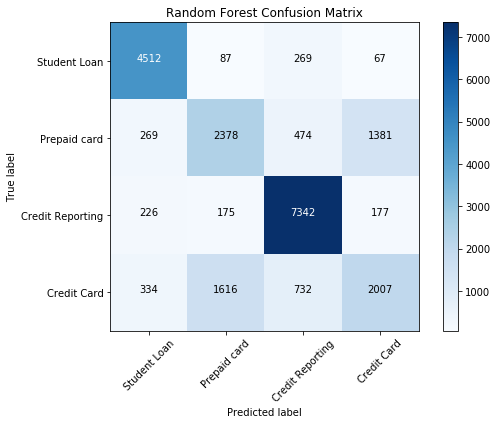

In [22]:
model_best = RF_cc
# class_names = list(model_best.classes_)
class_names = ["Student Loan", "Prepaid card", "Credit Reporting", "Credit Card"]

preds = model_best.predict(X_test)
#make sure that the labels are correct
cnf_matrix = confusion_matrix(y_test,preds)

plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Random Forest Confusion Matrix',
                      save = "RFcm.png")
plt.show()

#### Using gensim for Word2Vec
I wasn't quite able to figure out how to use word2vec with my consumer complaint data before the project was due, but here is a simple example of how it places similar words in close proximity in the vector space.

In [23]:
file_path = "C:/Users/Matt/Documents/Machine Learning/MathFeed Project/mfgitrepository/"
w2v = gensim.models.KeyedVectors.load_word2vec_format(file_path + 'GoogleNews-vectors-negative300.bin', binary=True)  

In [24]:
w2v.most_similar(positive=['shark'])

[('sharks', 0.852473258972168),
 ('whale', 0.7011443972587585),
 ('dolphin', 0.6842623949050903),
 ('stingray', 0.6708774566650391),
 ('tiger_sharks', 0.6664881110191345),
 ('bull_shark', 0.6542097330093384),
 ('crocodile', 0.6480218172073364),
 ('tiger_shark', 0.644328236579895),
 ('mako_shark', 0.6410458087921143),
 ('Shark', 0.632507860660553)]

In [25]:
w2v.most_similar(positive=['fox'])

[('foxes', 0.7762556672096252),
 ('squirrel', 0.679478108882904),
 ('rabbit', 0.6482738256454468),
 ('squirrels', 0.6386120319366455),
 ('coyote', 0.6145134568214417),
 ('owl', 0.6064995527267456),
 ('proverbial_fox_guarding', 0.605222225189209),
 ('gray_fox', 0.5987539291381836),
 ('critter', 0.5982018709182739),
 ('raccoon', 0.5971077680587769)]

#### Acknowledgements
- []()
- Chris McCormick's Word2Vec [Blogpost](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/)
- This [Blog](https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f) was helpful for finding and cleaning the customer complaint data set. (Author: Susan Li)
- Explanation [video](https://www.youtube.com/watch?v=aCdg-d_476Y) for Bag of Words


And of course a shout out to Tyler Folkman and his TA Conner Leavitt for making this course so beneficial for all of the students!